# **Multi-Class Skin Classifier**

# Setting Up Environment

In [1]:
!pip install barbar pytorch-ignite

In [2]:
pip install -q torch-summary

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Standard library imports
import random  # Random number generator
import warnings  # Controls the display of warning messages
warnings.filterwarnings('ignore')  # Ignores all warnings
import os  # Operating system

# Data manipulation and analysis
import pandas as pd  # Data structures like DataFrames
import numpy as np  # Supports for arrays and matrices

# Visualisation libraries
import seaborn as sns  # High-level interface for statistical graphics
import matplotlib.pyplot as plt  # Creates static, animated, and interactive visualisations
from tqdm import tqdm  # Progress bars for loops
from glob import glob

# PyTorch and related libraries
import torch  # Core library for PyTorch
import torch.nn as nn  # For creating and training neural networks
from torch.utils.data import DataLoader  # Data loaders for batch processing
from torchvision import transforms, datasets  # Image transformations and datasets
import torchvision  # Datasets, model architectures, and image transformations
from torchsummary import summary  # Summary of PyTorch models
from torch.utils.tensorboard import SummaryWriter  # Logging for TensorBoard
from barbar import Bar  # Progress bar for PyTorch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Utilities for mixed precision training to enhance performance
from torch.cuda.amp import autocast, GradScaler

# Machine learning metrics and model evaluation
from ignite.metrics import Accuracy  # Metric computations for model evaluation
from sklearn.metrics import (  # Evaluation functions for classification models
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_auc_score
)
from sklearn.model_selection import (  # Data splitting classes
    StratifiedKFold, 
    GroupKFold, 
    KFold
)

# High-level file operations
from shutil import copyfile, move  # Copy and move files

# Configuration and setup
plt.rcParams['font.family'] = 'Avenir'  # Set default font family for plots

2024-05-28 10:08:55.723655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 10:08:55.723766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 10:08:55.824075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Sets the device for computation to 'cuda' (GPU) if available, otherwise goes back to 'cpu' (Central Processing Unit). 
# This enables optimal use of hardware by leveraging GPU acceleration when possible.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Analysing the Data

In [5]:
# Shows the Input Data Lists from Kaggle Directories
os.listdir("/kaggle/input")

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

In [6]:
# Pulls the metadata and shows us the input types 
data = pd.read_csv('../input/HAM10000_metadata.csv')
tabular_data = pd.read_csv('../input/HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

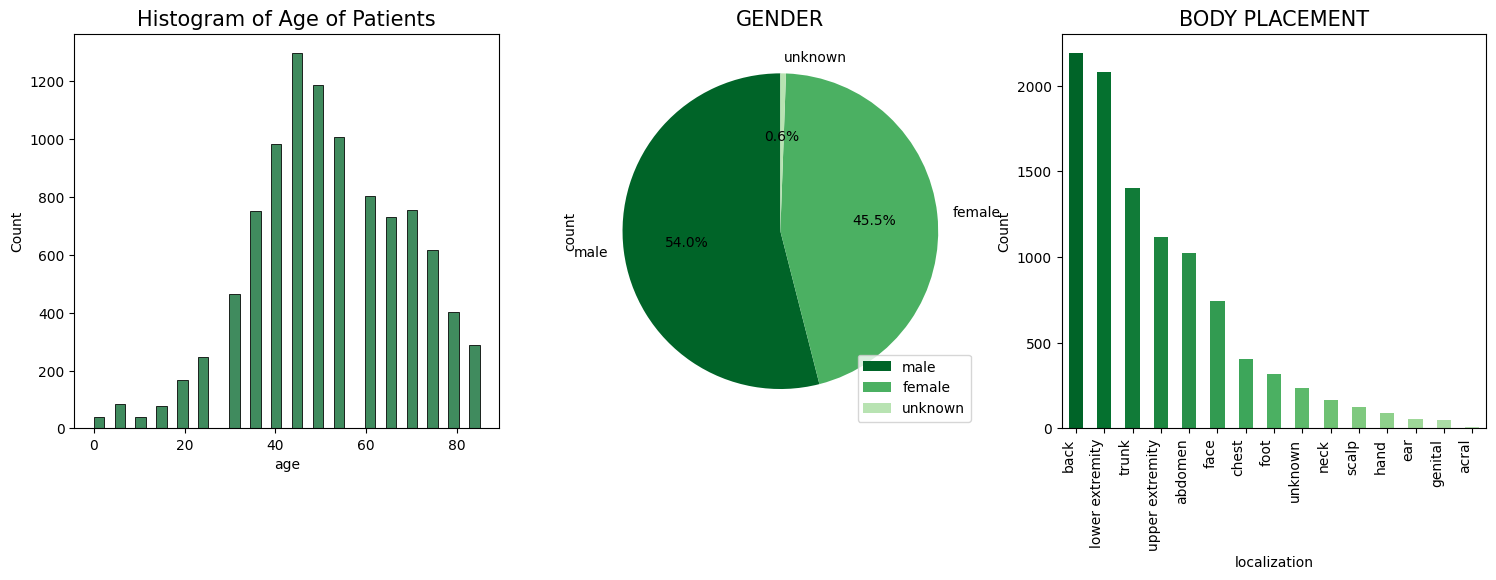

In [14]:
# Defines a function to generate a list of colors from a colormap with reversed gradient
def get_reversed_color_list(n, colormap='Greens'):
    cmap = plt.get_cmap(colormap)  # Gets the colormap object from Matplotlib
    colors = [cmap(i) for i in np.linspace(0.9, 0.3, n)]  # Generates 'n' colors from the colormap in reverse order - basically a gradient
    return colors

# Gets colour lists for each plot based on the number of unique values
age_colors = get_reversed_color_list(data['age'].nunique())  # Colours for 'age' plot
sex_colors = get_reversed_color_list(data['sex'].nunique())  # Colours for 'sex' plot
localization_colors = get_reversed_color_list(data['localization'].nunique())  # Colours for 'localisation' plot

plt.figure(figsize=(20, 10))  # Sets the figure size to 20x10 inches
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.8, hspace=0.5, wspace=0.3)  # Adjusts subplot layout for better spacing

# Plots the 'AGE' histogram
plt.subplot(2, 4, 1)  # Creates a subplot in a 2x4 grid, first subplot
plt.title("Histogram of Age of Patients", fontsize=15)  # Sets the title of the subplot
plt.ylabel("Count")  # Sets the y-axis label
sns.histplot(data['age'], color=age_colors[0])  # Plots the 'age' histogram with generated colors

# Plots the 'GENDER' pie chart
plt.subplot(2, 4, 2)  # Creates a subplot in a 2x4 grid, second subplot
plt.title("GENDER", fontsize=15)  # Sets the title of the subplot
data['sex'].value_counts().plot.pie(colors=sex_colors, autopct='%1.1f%%', startangle=90, legend=True)  # Plots the 'sex' pie chart with generated colors

# Plots the 'BODY PLACEMENT' bar chart
plt.subplot(2, 4, 3)  # Creates a subplot in a 2x4 grid, third subplot
plt.title("BODY PLACEMENT", fontsize=15)  # Sets the title of the subplot
plt.ylabel("Count")  # Sets the y-axis label
plt.xticks(rotation=45, ha='right')  # Rotates the x-axis labels by 45 degrees and align them to the right
data['localization'].value_counts().plot.bar(color=localization_colors)  # Plots the 'localization' bar chart with generated colors

plt.tight_layout()  # Adjusts subplots to fit into figure area.
plt.show()  # Displays all the plots

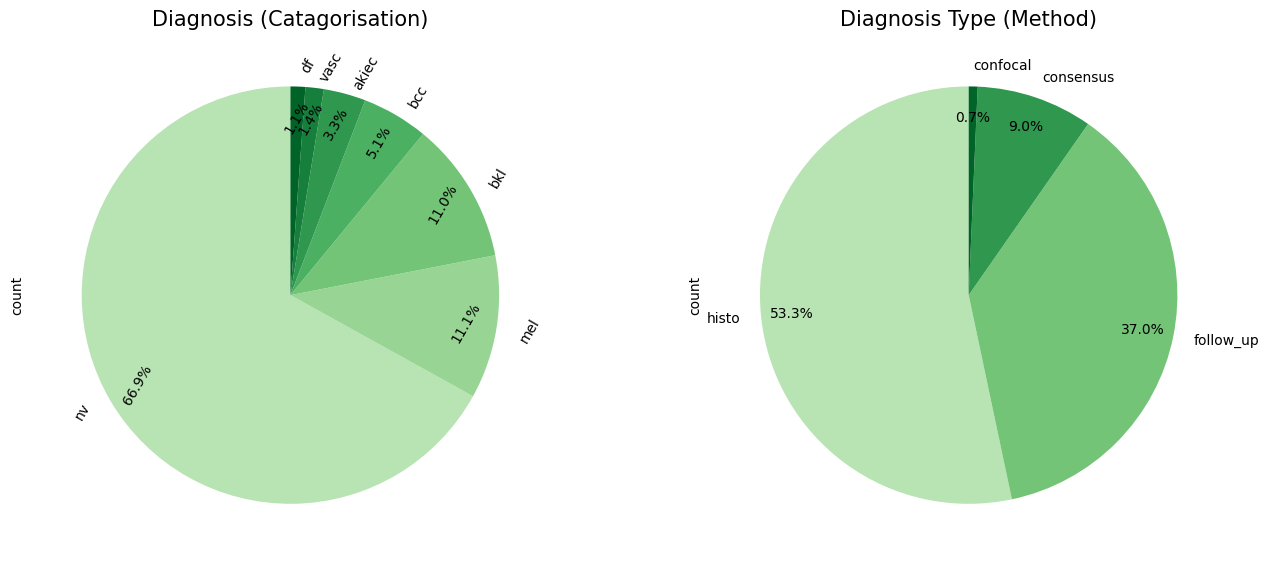

In [15]:
plt.figure(figsize=(15, 10))  # Sets the figure size to 15x10 inches

# Plots the first pie chart for 'Diagnosis Catagorisation'
plt.subplot(1, 2, 1)  # Creates a subplot in a 1x2 grid, first subplot
plt.title("Diagnosis (Catagorisation)", fontsize=15)  # Sets the title of the subplot
Pie_1 = data['dx'].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, colors=plt.cm.Greens(np.linspace(0.3, 0.9, data['dx'].nunique())), 
                                   pctdistance=0.85, labeldistance=1.1)
for text in Pie_1.texts:
    text.set_rotation(60)    # Plots the first pie chart without the labels overlapping
    
# Plots the second pie chart for 'Diagnosis Method'
plt.subplot(1, 2, 2)  # Creates a subplot in a 1x2 grid, second subplot
plt.title("Diagnosis Type (Method)", fontsize=15)  # Sets the title of the subplot
data['dx_type'].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, colors=plt.cm.Greens(np.linspace(0.3, 0.9, data['dx_type'].nunique())), pctdistance=0.85, labeldistance=1.1)  # Plot the 'dx_type' pie chart

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3)  # Adjusts subplot layout for better spacing
plt.show()  # Displays all the plots

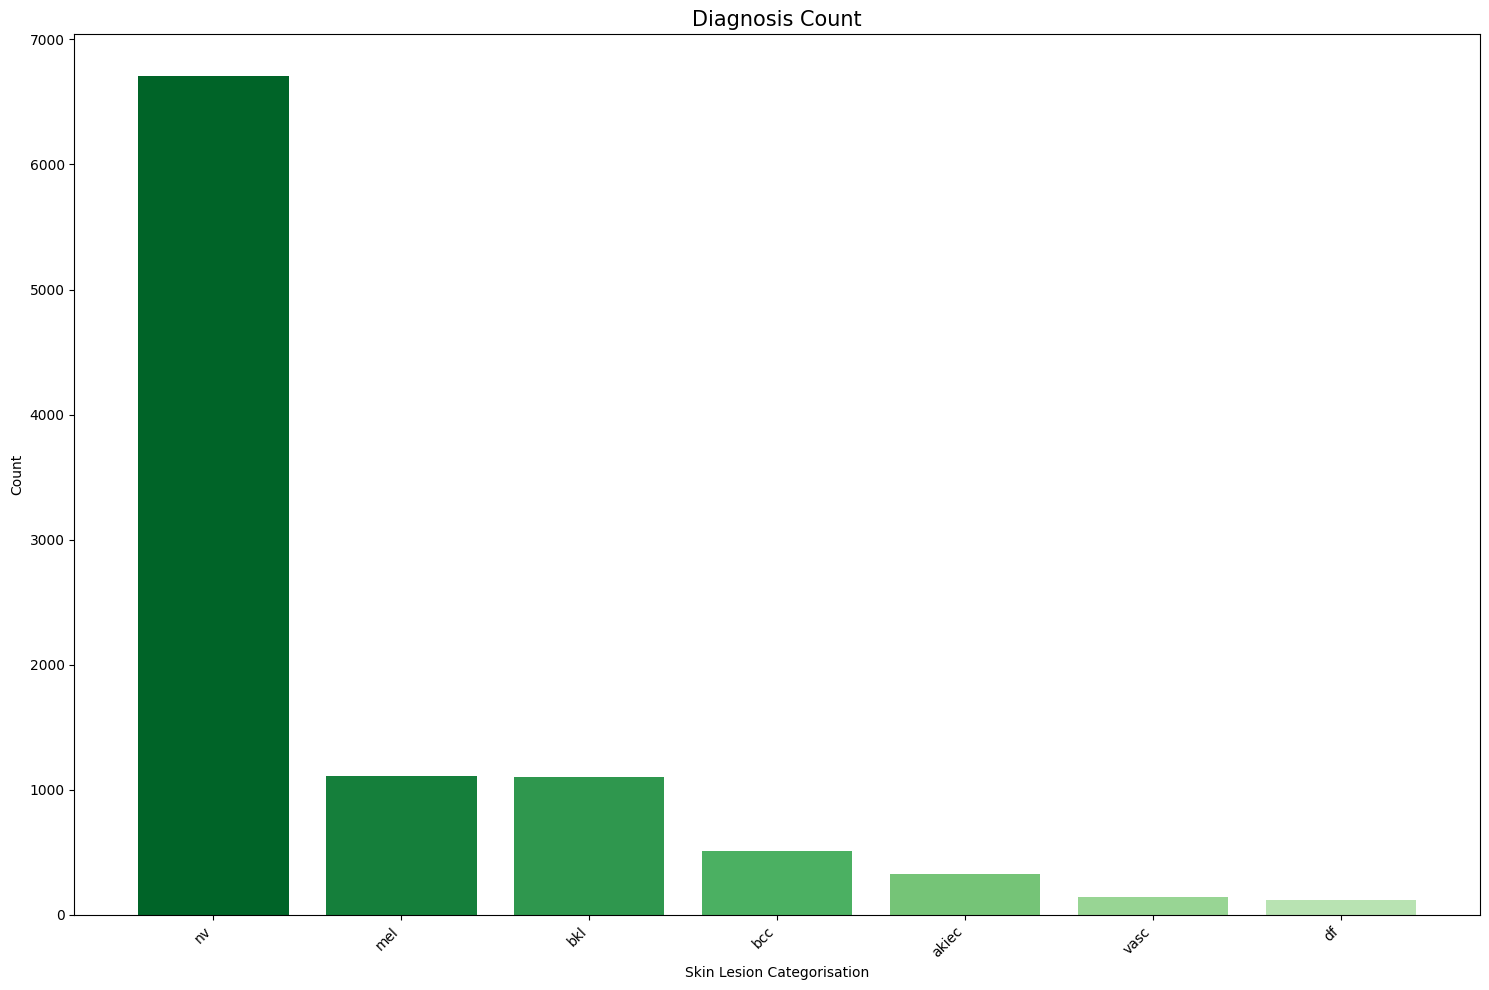

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [16]:
# Defines a function to generate a list of colours from a colormap with reversed gradient
def get_reversed_color_list(n, colormap='Greens'):
    cmap = plt.get_cmap(colormap)  # Gets the colourmap object from Matplotlib
    colors = [cmap(i) for i in np.linspace(0.9, 0.3, n)]  # Generates 'n' colours from the colormap in reverse order - again
    return colors

# Gets the value counts for 'dx'
dx_counts = data['dx'].value_counts()
dx_colors = get_reversed_color_list(dx_counts.size)  # Colours for 'dx' plot

# Plotting the 'dx' value counts as a bar chart
plt.figure(figsize=(15, 10))  # Set the figure size to 15x10 inches
plt.bar(dx_counts.index, dx_counts.values, color=dx_colors)  # Plot the 'dx' bar chart with generated colors

# Adding titles and labels
plt.title("Diagnosis Count", fontsize=15)  # Sets the title of the plot
plt.ylabel("Count")  # Sets the y-axis label
plt.xlabel("Skin Lesion Categorisation")  # Sets the x-axis label
plt.xticks(rotation=45, ha='right')  # Rotates the x-axis labels by 45 degrees and align them to the right

plt.tight_layout()  # Adjusts subplots to fit into figure area
plt.show()  # Displays the plot
data['dx'].value_counts()

# Defining Early Stopping

In [17]:
class EarlyStopping:
    # Earlys stops the training if validation loss doesn't improve after a given patience.
    
    def __init__(self, patience=15, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        # Initialises the EarlyStopping instance with the given parameters.
        # Args:
        #     patience (int): How long to wait after the last time validation loss improved. 
        #     verbose (bool): If True, prints a message for each validation loss improvement. 
        #     delta (float): Minimum change in the monitored quantity to qualify as an improvement. 
        #     path (str): Path for the checkpoint to be saved to. Default: 'checkpoint.pt'
        #     trace_func (function): Trace print function to be used for logging. Default: print
        
        self.patience = patience  # Number of epochs to wait for improvement
        self.verbose = verbose  # Whether to print messages about improvements
        self.counter = 0  # Counter for epochs without improvement
        self.best_score = None  # Best score encountered so far
        self.early_stop = False  # Flag for early stopping
        self.val_loss_min = np.Inf  # Minimum validation loss encountered
        self.delta = delta  # Minimum change to qualify as an improvement
        self.path = path  # Path to save the model checkpoint
        self.trace_func = trace_func  # Function for logging
    
    def __call__(self, val_loss, model):
        # Calls method to evaluate the validation loss and decide if early stopping is needed.
        # Args:
        #     val_loss (float): The current validation loss.
        #     model (torch.nn.Module): The model being trained.
        
        score = -val_loss  # Negative loss because we want to minimize loss
        
        if self.best_score is None:  # If no best score, set to current score
            self.best_score = score
            self.save_checkpoint(val_loss, model)  # Saves initial model
        elif score < self.best_score + self.delta:  # If no improvement
            self.counter += 1  # Increment counter
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')  # Log counter
            if self.counter >= self.patience:  # If counter exceeds patience, stop early
                self.early_stop = True
        else:  # If improvement
            self.best_score = score  # Updates best score
            self.save_checkpoint(val_loss, model)  # Saves model
            self.counter = 0  # Resets counter
    
    def save_checkpoint(self, val_loss, model):
        # Saves the model when the validation loss decreases.
        # Args:
        #     val_loss (float): The current validation loss.
        #     model (torch.nn.Module): The model being trained.
        
        if self.verbose:  # If verbose, prints improvement message
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        
        torch.save(model.state_dict(), f'/kaggle/working/skin_models/{self.path}')  # Save model state_dict
        self.val_loss_min = val_loss  # Updates minimum validation loss

# Slitting into Test and Train

In [18]:
def split_data(source, training, test, split_size):
    # Splits data from a source directory into training and test sets.
    # Args:
    #     source (str): The source directory containing the files to split.
    #     training (str): The destination directory for the training set.
    #     test (str): The destination directory for the test set.
    #     split_size (float): The proportion of data to be used for training (between 0 and 1).
    
    files = []  # Initialises an empty list to hold the filenames
    
    # Iterates over all files in the source directory
    for filename in os.listdir(source):
        file = source + filename  # Gets the full path of the file
        if os.path.getsize(file) > 0:  # Checks if the file is not empty
            files.append(filename)  # Adds the filename to the list
        else:
            print(filename + " is zero length, so ignoring.")  # Prints a message if the file is empty

    training_length = int(len(files) * split_size)  # Numbers of files for the training set
    test_length = len(files) - training_length  # Numbers of files for the test set
    
    shuffled_set = random.sample(files, len(files))  # Shuffles the list of files
    training_set = shuffled_set[:training_length]  # Splits into training set
    test_set = shuffled_set[training_length:]  # Splits into test set

    # Copies the training set files to the training directory
    for filename in training_set:
        this_file = source + filename  # Full path of the source file
        destination = training + filename  # Full path of the destination file
        copyfile(this_file, destination)  # Copy the file to the destination

    # Copies the test set files to the test directory
    for filename in test_set:
        this_file = source + filename  # Full path of the source file
        destination = test + filename  # Full path of the destination file
        copyfile(this_file, destination)  # Copy the file to the destination

# Creating Directories

In [19]:
# Creates the main directory for skin models
os.mkdir('/kaggle/working/skin_models/')

# Creates the main directory for original data
os.mkdir('/kaggle/working/orig/')

# Creates subdirectories for each class in the original data
os.mkdir('/kaggle/working/orig/0.MEL/')  # Melanoma
os.mkdir('/kaggle/working/orig/1.NV/')   # Melanocytic Nevi
os.mkdir('/kaggle/working/orig/2.BCC/')  # Basal Cell Carcinoma
os.mkdir('/kaggle/working/orig/3.AKIEC/')# Actinic Keratoses
os.mkdir('/kaggle/working/orig/4.BKL/')  # Benign Keratosis
os.mkdir('/kaggle/working/orig/5.DF/')   # Dermatofibroma
os.mkdir('/kaggle/working/orig/6.VASC/') # Vascular Lesions

# Creates the main directory for processed skin data
os.mkdir('/kaggle/working/skin/')

# Creates subdirectories for training and test datasets
os.mkdir('/kaggle/working/skin/training/')
os.mkdir('/kaggle/working/skin/test/')

# Creates subdirectories for each class in the training set
os.mkdir('/kaggle/working/skin/training/0.MEL/')  # Melanoma
os.mkdir('/kaggle/working/skin/training/1.NV/')   # Melanocytic Nevi
os.mkdir('/kaggle/working/skin/training/2.BCC/')  # Basal Cell Carcinoma
os.mkdir('/kaggle/working/skin/training/3.AKIEC/')# Actinic Keratoses
os.mkdir('/kaggle/working/skin/training/4.BKL/')  # Benign Keratosis
os.mkdir('/kaggle/working/skin/training/5.DF/')   # Dermatofibroma
os.mkdir('/kaggle/working/skin/training/6.VASC/') # Vascular Lesions

# Creates subdirectories for each class in the test set
os.mkdir('/kaggle/working/skin/test/0.MEL/')  # Melanoma
os.mkdir('/kaggle/working/skin/test/1.NV/')   # Melanocytic Nevi
os.mkdir('/kaggle/working/skin/test/2.BCC/')  # Basal Cell Carcinoma
os.mkdir('/kaggle/working/skin/test/3.AKIEC/')# Actinic Keratoses
os.mkdir('/kaggle/working/skin/test/4.BKL/')  # Benign Keratosis
os.mkdir('/kaggle/working/skin/test/5.DF/')   # Dermatofibroma
os.mkdir('/kaggle/working/skin/test/6.VASC/') # Vascular Lesions

In [20]:
# This block of code defines variables that store the paths to the directories created in the first block.
# Defines the path to the source directory containing the HAM10000 dataset
orig_all = '/kaggle/working/HAM10000/'

# Defines the paths to the source directories for each skin lesion class in the original dataset
source_MEL = '/kaggle/working/orig/0.MEL/'  # Melanoma
source_NV = '/kaggle/working/orig/1.NV/'    # Melanocytic Nevi
source_BCC = '/kaggle/working/orig/2.BCC/'  # Basal Cell Carcinoma
source_AKIEC = '/kaggle/working/orig/3.AKIEC/'  # Actinic Keratoses and Intraepithelial Carcinoma
source_BKL = '/kaggle/working/orig/4.BKL/'  # Benign Keratosis
source_DF = '/kaggle/working/orig/5.DF/'    # Dermatofibroma
source_VASC = '/kaggle/working/orig/6.VASC/'# Vascular Lesions

# Defines the paths to the training directories for each skin lesion class
training_MEL = '/kaggle/working/skin/training/0.MEL/'  # Melanoma
training_NV = '/kaggle/working/skin/training/1.NV/'    # Melanocytic Nevi
training_BCC = '/kaggle/working/skin/training/2.BCC/'  # Basal Cell Carcinoma
training_AKIEC = '/kaggle/working/skin/training/3.AKIEC/'  # Actinic Keratoses and Intraepithelial Carcinoma
training_BKL = '/kaggle/working/skin/training/4.BKL/'  # Benign Keratosis
training_DF = '/kaggle/working/skin/training/5.DF/'    # Dermatofibroma
training_VASC = '/kaggle/working/skin/training/6.VASC/'# Vascular Lesions

# Defines the paths to the test directories for each skin lesion class
test_MEL = '/kaggle/working/skin/test/0.MEL/'  # Melanoma
test_NV = '/kaggle/working/skin/test/1.NV/'    # Melanocytic Nevi
test_BCC = '/kaggle/working/skin/test/2.BCC/'  # Basal Cell Carcinoma
test_AKIEC = '/kaggle/working/skin/test/3.AKIEC/'  # Actinic Keratoses and Intraepithelial Carcinoma
test_BKL = '/kaggle/working/skin/test/4.BKL/'  # Benign Keratosis
test_DF = '/kaggle/working/skin/test/5.DF/'    # Dermatofibroma
test_VASC = '/kaggle/working/skin/test/6.VASC/'# Vascular Lesions


In [21]:
# Creates a directory to store the original HAM10000 dataset files
os.mkdir('/kaggle/working/HAM10000/')

In [22]:
# Defines the paths to the two parts of the HAM10000 dataset
part1 = "/kaggle/input/HAM10000_images_part_1"
part2 = "/kaggle/input/HAM10000_images_part_2"

# Iterates over both parts of the dataset
for part in [part1, part2]:
    # Iterate over each image file in the current part directory
    for img in tqdm(os.listdir(part)):
        # Copy the image file from the source directory to the destination directory
        copyfile(os.path.join(part, img), os.path.join('/kaggle/working/HAM10000/', img))

100%|██████████| 5015/5015 [01:17<00:00, 64.83it/s]


In [23]:
# Removes duplicates from the dataset based on the 'lesion_id' column
data = data.drop_duplicates(subset='lesion_id')

# Manual inspection of what is left in the dataset
print(len(data))  # Print the number of unique lesions remaining in the dataset

# Extract image names into a list from the 'image_id' column
image_names = [x for x in data['image_id']]

# Extract diagnoses into a list from the 'dx' column
diagnosis = [x for x in data['dx']]

# Print the length of the image_names list to verify extraction
print(len(image_names))

# Print the length of the diagnosis list to verify extraction
print(len(diagnosis))

# Print the first image name in the list for inspection
print(image_names[0])

# Print the first diagnosis in the list for inspection
print(diagnosis[0])

# Prints the unique labels to check there are still 7 classes
pd.unique(data['dx'])

7470
7470
7470
ISIC_0027419
bkl


array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [24]:
# Iterates over the image names and their corresponding indices using tqdm for a progress bar
for index, image in tqdm(enumerate(image_names)):
    # Append the '.jpg' extension to each image name
    image = image + '.jpg'
    
    # Check the diagnosis for the current image and copy the file to the corresponding directory
    if diagnosis[index] == 'mel':
        copyfile(os.path.join(orig_all, image), os.path.join(source_MEL, image))
    elif diagnosis[index] == 'nv':
        copyfile(os.path.join(orig_all, image), os.path.join(source_NV, image))
    elif diagnosis[index] == 'bcc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_BCC, image))
    elif diagnosis[index] == 'akiec': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_AKIEC, image))
    elif diagnosis[index] == 'bkl':
        copyfile(os.path.join(orig_all, image), os.path.join(source_BKL, image))
    elif diagnosis[index] == 'df':  
        copyfile(os.path.join(orig_all, image), os.path.join(source_DF, image))
    elif diagnosis[index] == 'vasc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_VASC, image))

7470it [00:02, 3196.88it/s]


In [25]:
# Prints amount of pictures for each class
print(len(os.listdir(source_MEL)))
print(len(os.listdir(source_NV)))
print(len(os.listdir(source_BCC)))
print(len(os.listdir(source_AKIEC)))
print(len(os.listdir(source_BKL)))
print(len(os.listdir(source_DF)))
print(len(os.listdir(source_VASC)))

614
5403
327
228
727
73
98


# Splitting the Data

In [31]:
# Splits all the training and testing for each class of skin lesion
split_size = 0.9
split_data(source_MEL, training_MEL, test_MEL, split_size)
split_data(source_NV, training_NV, test_NV, split_size)
split_data(source_BCC, training_BCC,test_BCC, split_size)
split_data(source_AKIEC, training_AKIEC,test_AKIEC, split_size)
split_data(source_BKL, training_BKL,test_BKL, split_size)
split_data(source_DF, training_DF,test_DF, split_size)
split_data(source_VASC, training_VASC,test_VASC, split_size)

In [32]:
# Prints amount of pictures for each class after split, train/val.
print(len(os.listdir(training_MEL)))
print(len(os.listdir(test_MEL)))
# print(len(os.listdir(validation_MEL)))
print(len(os.listdir(training_NV)))
print(len(os.listdir(test_NV)))
# print(len(os.listdir(validation_NV)))
print(len(os.listdir(training_BCC)))
print(len(os.listdir(test_BCC)))
# print(len(os.listdir(validation_BCC)))
print(len(os.listdir(training_AKIEC)))
print(len(os.listdir(test_AKIEC)))
# print(len(os.listdir(validation_AKIEC)))
print(len(os.listdir(training_BKL)))
print(len(os.listdir(test_BKL)))
# print(len(os.listdir(validation_BKL)))
print(len(os.listdir(training_DF)))
print(len(os.listdir(test_DF)))
# print(len(os.listdir(validation_DF)))
print(len(os.listdir(training_VASC)))
print(len(os.listdir(test_VASC)))
# print(len(os.listdir(validation_VASC)))

552
62
4862
541
294
33
205
23
654
73
65
8
88
10


In [33]:
# Stores the Training and Testing datasets
traindir = r'/kaggle/working/skin/training/'
testdir = r'/kaggle/working/skin/test/'

Found classes: ['5.DF', '2.BCC', '1.NV', '4.BKL', '3.AKIEC', '0.MEL', '6.VASC']


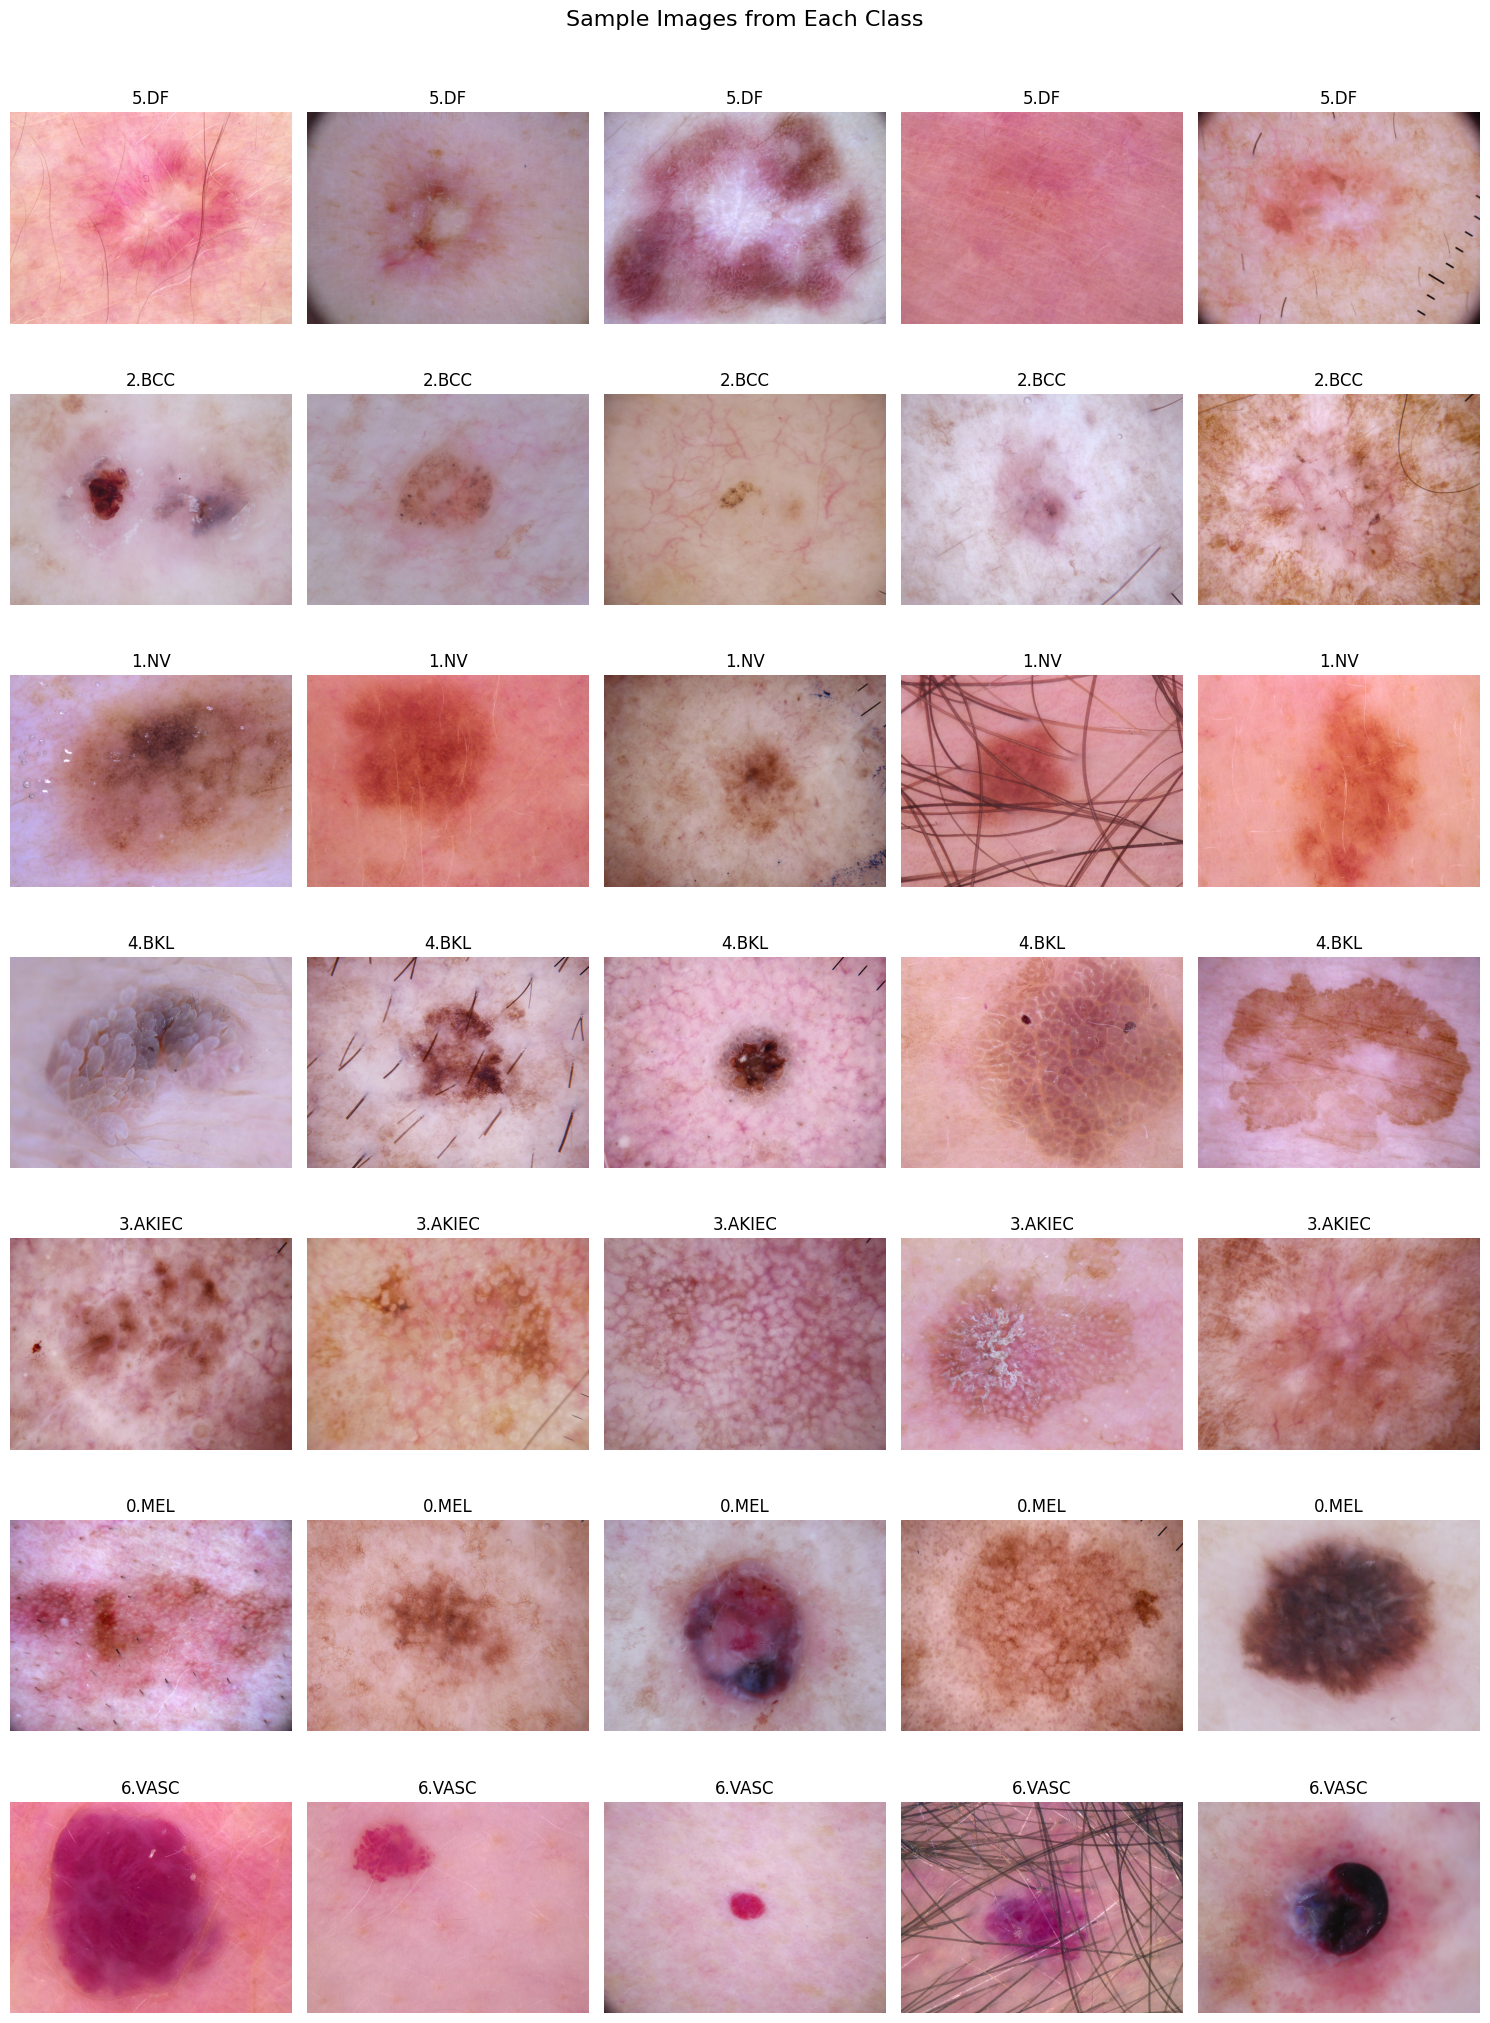

In [34]:
# Sets the path to the dataset
dataset_path = '/kaggle/working/skin/training/'

# Defines a function to retrieve 5 images from each class
def retrieve_sample_images(dataset_path, num_samples=5):
    # Dictionary to store class names and their corresponding images
    class_images = {}
    
    # Gets the list of class directories
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    print(f"Found classes: {classes}")
    
    # Loops through each class and retrieve images
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        images = glob(os.path.join(class_dir, '*.jpg'))  # Assuming images are in .jpg format
        if len(images) < num_samples:
            print(f"Warning: Found only {len(images)} images in class {class_name}")
        # Randomly sample 5 images from each class
        sampled_images = random.sample(images, min(len(images), num_samples))
        class_images[class_name] = sampled_images
    
    return class_images

# Retrieves sample images
sample_images = retrieve_sample_images(dataset_path, num_samples=5)

# Displays the sampled images
def display_sample_images(sample_images):
    num_classes = len(sample_images)
    if num_classes == 0:
        print("No classes found or no images in classes.")
        return
    
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, num_classes * 3))
    fig.suptitle('Sample Images from Each Class', fontsize=16)
    
    for i, (class_name, images) in enumerate(sample_images.items()):
        for j, img_path in enumerate(images):
            img = Image.open(img_path)
            if num_classes > 1:
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'{class_name}')
                axes[i, j].axis('off')
            else:  # Handle single row of images
                axes[j].imshow(img)
                axes[j].set_title(f'{class_name}')
                axes[j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Displays the images
display_sample_images(sample_images)

# Data Augmentation

In [ ]:
# Defines a series of transformations for the training set
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),  # Resize the image to 224x280 pixels
    transforms.CenterCrop((224, 224)),  # Centre crop the image to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),  # Randomly apply a rotation between -180 and 180 degrees with a probability of 0.99
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor with the mean and standard deviation values used in pre-trained models
])

# Defines a series of transformations for the validation set
val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),  # Resize the image to 224x280 pixels
    transforms.CenterCrop((224, 224)),  # Center crop the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor with the mean and standard deviation values used in pre-trained models
])

# Defines a series of transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 280)),  # Resize the image to 224x280 pixels
    transforms.CenterCrop((224, 224)),  # Center crop the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor with the mean and standard deviation values used in pre-trained models
])

# Creates the training dataset from the images in the training directory, applying the defined transformations
train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

# Creates the test dataset from the images in the test directory, applying the defined transformations
test_dataset = datasets.ImageFolder(
    testdir, transform=test_transforms)


# Test/Train Dataloaders

In [ ]:
# Creates a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # The dataset to load data from
    batch_size=64,  # Number of samples per batch to load
    shuffle=True,  # Shuffle the data at every epoch to ensure randomization
    pin_memory=False,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them (useful when using a GPU)
    drop_last=False  # If True, drops the last incomplete batch if the dataset size is not divisible by the batch size
)

In [ ]:
# Same as above but for testing dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=True,
    pin_memory=False, 
    drop_last=False
)

# Model Initialisation and K-Folding

In [ ]:
batchSize = 32  # Defines the batch size for training and validation
num_folds = 5  # Defines the number of folds for K-Fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Initialize K-Fold cross-validation with 5 splits, shuffling the data and setting a random state for reproducibility
MODEL_RESULTS = {}  # Initialises an empty dictionary to store results for each fold

device = 'cuda'  # Defines/checks one more time that the device to use for training (GPU if available)
epochs = 75# Defines the number of epochs for training

# Performs K-Fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(train_loader.dataset)):
    temp_val_loss = []  # Initialises a list to store validation losses for the current fold
    temp_val_acc = []  # Initialises a list to store validation accuracies for the current fold
    temp_train_loss = []  # Initialises a list to store training losses for the current fold
    temp_train_acc = []  # Initialises a list to store training accuracies for the current fold
    
    # Loads the pre-trained ResNet50 model and adjust the final layer for 7 classes
    model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)
    model.fc = nn.Linear(2048, 7).to(device)  # Change the final fully connected layer to output 7 classes
    criterion = nn.CrossEntropyLoss()  # Defines the loss function
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)  # Defines the optimizer with weight decay

    # Initialises early stopping with patience of 75 epochs - combats early stopping due to large variation
    early_stopping = EarlyStopping(patience=15, path=f"best_model_fold{fold}.pth", verbose=True)
    
    print('=' * 20, 'Fold', fold, '=' * 20)  
    
    # Obtains the data for the current fold
    train_data_fold = torch.utils.data.Subset(train_loader.dataset, train_index)  # Subset for training data
    val_data_fold = torch.utils.data.Subset(train_loader.dataset, val_index)  # Subset for validation data

    # Creates data loaders for the current fold
    train_loader_fold = DataLoader(train_data_fold, batch_size=batchSize, shuffle=True, num_workers=4)  # Training data loader
    val_loader_fold = DataLoader(val_data_fold, batch_size=batchSize, shuffle=False, num_workers=4)  # Validation data loader
    
    # Training and validation for each epoch
    for epoch in range(epochs):
        train_loss = 0.00  # Initialises the training loss for the epoch
        val_loss = 0.00  # Initialises the validation loss for the epoch
        train_accuracy = Accuracy()  # Initialise the training accuracy metric
        val_accuracy = Accuracy()  # Initialises the validation accuracy metric
        print(f'Epoch {epoch+1}')

        # Training loop
        for idx, (inputs, labels) in enumerate(Bar(train_loader_fold)):
            model.train()  # Sets the model to training mode
            inputs, labels = inputs.to(device), labels.to(device)  # Moves inputs and labels to the device
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Computes the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Updates the weights
            train_loss += loss.item()  # Accumulates the training loss
            train_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))  # Updates the training accuracy
        
        # Computes and prints training accuracy
        print(f"Train Accuracy: {train_accuracy.compute()}")
        train_loss /= len(train_loader_fold)  # Computes average training loss
        train_loss_formated = "{:.4f}".format(train_loss)  # Formats the training loss
        
        temp_train_loss.append(train_loss_formated)  # Store the formatted training loss
        temp_train_acc.append(round(train_accuracy.compute(), 4))  # Store the training accuracy

        # Validation loop
        with torch.no_grad():  # Disables gradient computation
            for inputs, labels in val_loader_fold:
                model.eval()  # Sets the model to evaluation mode
                inputs, labels = inputs.to(device), labels.to(device)  # Moves inputs and labels to the device
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Computes the loss
                val_loss += loss.item()  # Accumulates the validation loss
                val_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))  # Updates the validation accuracy
        
        # Computes and print validation accuracy
        print(f"Val Accuracy: {val_accuracy.compute()}")
        val_loss /= len(val_loader_fold)  # Computes average validation loss
        val_loss_formated = "{:.4f}".format(val_loss)  # Formats the validation loss
        print(f'Training Loss: {train_loss_formated}')  # Prints the training loss
        print(f"Validation Loss: {val_loss_formated}")  # Prints the validation loss
        temp_val_loss.append(val_loss_formated)  # Stores the formatted validation loss
        temp_val_acc.append(round(val_accuracy.compute(), 4))  # Stores the validation accuracy

        # Early stopping check
        early_stopping(val_loss, model)  # Checks if early stopping should be applied
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Stores the results for the current fold
    MODEL_RESULTS[fold] = {
        'val_loss': temp_val_loss,
        'val_acc': temp_val_acc,
        'train_loss': temp_train_loss,
        'train_acc': temp_train_acc
    }

In [ ]:
# Lists all saved model files in the specified directory
SavedModels = os.listdir("/kaggle/working/skin_models")

# Outputs the list of saved model files
SavedModels

In [ ]:
# Now again but in sorted order
SavedModels = sorted(SavedModels,key=lambda x:x.split('.')[0][-1])
SavedModels

# Assessing the Results

In [ ]:
# Sets the number of classes
num_classes = 7
# Initialises an array to accumulate confusion matrices
total_conf_mat = np.zeros((num_classes, num_classes))

# Iterates over each saved model corresponding to different folds
for fold_id, mdle in enumerate(SavedModels):
    print(f'===============Fold-{fold_id} Model-> {mdle}==================')
    
    # Loads the last checkpoint with the best model
    model.load_state_dict(torch.load(f'/kaggle/working/skin_models/{mdle}'))   

    # Initialises tensors to hold predictions and actual labels
    predlist = torch.zeros(0, dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0, dtype=torch.long, device='cpu')
    predlistauc = torch.zeros(0, dtype=torch.float32, device='cpu')
    
    # Disables gradient computation for evaluation
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            model.eval()  # Sets the model to evaluation mode
            inputs = inputs.to(device)  # Moves inputs to the GPU
            classes = classes.to(device)  # Moves classes to the GPU
            outputs = model(inputs)  # Performs forward pass
            _, preds = torch.max(outputs, 1)  # Gets the predictions with the highest score

            # Appends batch prediction results to the lists
            predlist = torch.cat([predlist, preds.view(-1).cpu()])
            lbllist = torch.cat([lbllist, classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc, F.softmax(outputs, dim=1).cpu()])
    
    # Converts tensors to numpy arrays for further processing
    predlist = predlist.numpy()
    lbllist = lbllist.numpy()
    predlistauc = predlistauc.numpy()

    # Generates the confusion matrix and add to the total confusion matrix
    conf_mat = confusion_matrix(lbllist, predlist)
    total_conf_mat += conf_mat
    
    target_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    cm_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]  # Normalises the confusion matrix
    print(classification_report(lbllist, predlist, target_names=target_names))  # Prints the classification report
    
    # Compute the AUC for each class
    lbllist_one_hot = F.one_hot(torch.tensor(lbllist), num_classes=num_classes)
    every_auc = roc_auc_score(lbllist_one_hot, predlistauc, multi_class='ovr', average=None)
    
    # Prints the AUC for each class
    for i, every in enumerate(target_names):
        print(f'AUC of class {every} = {every_auc[i]}')
    
    # Creates and plot the confusion matrix with a green color map
    disp = ConfusionMatrixDisplay(cm_normalized, display_labels=target_names)
    disp.plot(cmap='Greens', values_format=".2f")
    plt.title(f'Confusion Matrix for Fold {fold_id}')
    plt.show()

# Computes the average confusion matrix
average_conf_mat = total_conf_mat / len(SavedModels)
cm_normalized_avg = average_conf_mat.astype('float') / average_conf_mat.sum(axis=1)[:, np.newaxis]

# Plots the final averaged confusion matrix
disp = ConfusionMatrixDisplay(cm_normalized_avg, display_labels=target_names)
disp.plot(cmap='Greens', values_format=".2f")
plt.title('Averaged Confusion Matrix')
plt.show()

In [ ]:
# Lists the model results for training and validation accuracy
MODEL_RESULTS[4]

In [ ]:
num_models = 5  # Number of models in MODEL_RESULTS

# Initialises lists to store average losses and accuracies
avg_val_loss = []
avg_val_accuracy = []
avg_train_loss = []
avg_train_accuracy = []

# To handle different lengths, find the minimum length across all models
min_length = min(len(MODEL_RESULTS[i]['val_loss']) for i in range(num_models))

# Function to apply moving average
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plots validation loss and accuracy for each model using subplots
plt.figure(figsize=(8, 5 * (num_models + 1)))  # Increase figure size to accommodate additional average plots

# Loops through each model to plot its validation and training metrics
for i in range(num_models):
    model_name = i  # Set the current model name (index)
    val_loss = [float(j) for j in MODEL_RESULTS[model_name]['val_loss'][:min_length]]  # Extract and truncate validation loss for current model
    val_accuracy = MODEL_RESULTS[model_name]['val_acc'][:min_length]  # Extract and truncate validation accuracy for current model
    
    train_loss = [float(j) for j in MODEL_RESULTS[model_name]['train_loss'][:min_length]]  # Extract and truncate training loss for current model
    train_accuracy = MODEL_RESULTS[model_name]['train_acc'][:min_length]  # Extract and truncate training accuracy for current model
    
    epochs = range(1, min_length + 1)  # Define the range of epochs based on the truncated length
    
    # Initialises average lists if they are empty and of the appropriate length
    if len(avg_val_loss) == 0:
        avg_val_loss = np.zeros(min_length)
        avg_val_accuracy = np.zeros(min_length)
        avg_train_loss = np.zeros(min_length)
        avg_train_accuracy = np.zeros(min_length)
    
    # Accumulates losses and accuracies for averaging
    avg_val_loss += np.array(val_loss)
    avg_val_accuracy += np.array(val_accuracy)
    avg_train_loss += np.array(train_loss)
    avg_train_accuracy += np.array(train_accuracy)

    # Subplots for validation loss
    plt.subplot(num_models + 1, 2, 2 * i + 1)  # (num_models + 1) rows, 2 columns, 1st subplot for current model
    plt.plot(epochs, val_loss, '-', color='lightgreen', label='Validation Loss')  # Plot validation loss
    plt.plot(epochs, train_loss, '-', color='darkgreen', label='Training Loss')  # Plot training loss
    plt.title(f'Fold-{model_name}: Loss Over Epochs')  # Set the title for the subplot
    plt.xlabel('Epoch')  # Label the x-axis
    plt.ylabel('Loss')  # Label the y-axis
    plt.legend()  # Display the legend

    # Subplots for validation accuracy
    plt.subplot(num_models + 1, 2, 2 * i + 2)  # (num_models + 1) rows, 2 columns, 2nd subplot for current model
    plt.plot(epochs, val_accuracy, '-', color='lightgreen', label='Validation Accuracy')  # Plot validation accuracy
    plt.plot(epochs, train_accuracy, '-', color='darkgreen', label='Training Accuracy')  # Plot training accuracy
    plt.title(f'Fold-{model_name}: Accuracy Over Epochs')  # Set the title for the subplot
    plt.xlabel('Epoch')  # Label the x-axis
    plt.ylabel('Accuracy')  # Label the y-axis
    plt.legend()  # Display the legend

# Calculates average losses and accuracies by dividing by the number of models
avg_val_loss /= num_models
avg_val_accuracy /= num_models
avg_train_loss /= num_models
avg_train_accuracy /= num_models

# Apply moving average to smooth the averages
window_size = 3  # You can adjust the window size
smoothed_avg_val_loss = moving_average(avg_val_loss, window_size)
smoothed_avg_val_accuracy = moving_average(avg_val_accuracy, window_size)
smoothed_avg_train_loss = moving_average(avg_train_loss, window_size)
smoothed_avg_train_accuracy = moving_average(avg_train_accuracy, window_size)

# Adjust epochs range for the smoothed data
smoothed_epochs = range(1, len(smoothed_avg_val_loss) + 1)

# Plots average validation loss and accuracy
plt.subplot(num_models + 1, 2, 2 * num_models + 1)  # (num_models + 1) rows, 2 columns, 1st subplot for average
plt.plot(smoothed_epochs, smoothed_avg_val_loss, '-', color='lightgreen', label='Average Validation Loss')  # Plot average validation loss
plt.plot(smoothed_epochs, smoothed_avg_train_loss, '-', color='darkgreen', label='Average Training Loss')  # Plot average training loss
plt.title('Average Loss Over Epochs')  # Set the title for the average loss subplot
plt.xlabel('Epoch')  # Label the x-axis
plt.ylabel('Loss')  # Label the y-axis
plt.legend()  # Display the legend

# Plots average validation accuracy
plt.subplot(num_models + 1, 2, 2 * num_models + 2)  # (num_models + 1) rows, 2 columns, 2nd subplot for average
plt.plot(smoothed_epochs, smoothed_avg_val_accuracy, '-', color='lightgreen', label='Average Validation Accuracy')  # Plot average validation accuracy
plt.plot(smoothed_epochs, smoothed_avg_train_accuracy, '-', color='darkgreen', label='Average Training Accuracy')  # Plot average training accuracy
plt.title('Average Accuracy Over Epochs')  # Set the title for the average accuracy subplot
plt.xlabel('Epoch')  # Label the x-axis
plt.ylabel('Accuracy')  # Label the y-axis
plt.legend()  # Display the legend

plt.tight_layout()  # Adjusts layout to prevent overlap
plt.show()  # Shows the plots


# Prediction

In [ ]:
# Defines the device to use for training and evaluation (GPU if available)
device = 'cuda'

# Loads the pre-trained ResNet50 model from torchvision and move it to the GPU
model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

# Modifies the final fully connected layer of the ResNet50 model to output 7 classes
# This adapts the model for the specific classification task with 7 classes - again!
model.fc = nn.Linear(2048, 7).to(device)

# Load the last checkpoint with the best model parameters for fold 4
# This loads the pre-trained weights saved during the training process
model.load_state_dict(torch.load('/kaggle/working/skin_models/best_model_fold4.pth'))

In [ ]:
# train_dataset.class_to_idx
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
image_path = "/kaggle/input/HAM10000_images_part_1/ISIC_0027960.jpg"

unseen_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert("RGB")
image = unseen_transforms(image)

# Reshapes the image to add batch dimension
image = image.unsqueeze(0) 

with torch.no_grad():
    model.eval()
    inputs = image.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    print(target_names[preds[0].item()]) # Prints the image diagnosis